<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Recurrent Neural Networks (RNNs)

_Author: Riley Dallas (ATX), Patrick Wales-Dinan (SF), Noah Christiansen_

---


### Learning Objectives

- Learn how to train/test split for sequence data
- Use `TimeseriesGenerator` to prep our time series data for modeling
- Create a basic RNN model using `keras`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.callbacks import EarlyStopping

## Load data: AAPL stock prices

We will use the [AlphaVantage API](https://www.alphavantage.co/documentation/) to gather Apple stock data for the last 20 years or so. Though you are also welcome to query another stock ticker if you would like.

Below is a helper function for querying the API. You can obtain a free API key from AlphaVantage, but we can also use any string in place of one.

In [2]:
def get_stock_data(symbol, function = "TIME_SERIES_DAILY",
                   interval = "5min", ## only used with TIME_SERIES_INTRADAY function
                   apikey = "key", outputsize = "compact"):
    base_url = "https://www.alphavantage.co/query"

    res = requests.get(url = base_url, params = {
            "function":function,
            "symbol":symbol,
            "interval":interval,
            "apikey":apikey,
            "outputsize":outputsize
    })
    
    data = res.json()
    data_key = list(data.keys())[1]
    data_df = pd.DataFrame(data[data_key]).T
    
    data_df.index = pd.to_datetime(data_df.index)
    data_df.sort_index(inplace = True)
    data_df.rename(columns = {
        "1. open":"Open",
        "2. high":"High",
        "3. low":"Low",
        "4. close":"Close",
        "5. volume":"Volume"}, inplace = True)
    
    return data_df.astype(float)

In [3]:
prices = get_stock_data("AAPL", outputsize = "full")
print(prices.shape)
prices.head()

(5623, 5)


,Open,High,Low,Close,Volume
1999-11-01,80.00,80.69,77.37,77.62,2487300.0
1999-11-02,78.00,81.69,77.31,80.25,3564600.0
1999-11-03,81.62,83.25,81.00,81.50,2932700.0
1999-11-04,82.06,85.37,80.62,83.62,3384700.0
1999-11-05,84.62,88.37,84.00,88.31,3721500.0


## `DateTime` Index
---

Since these are time series datasets, we need the indices to be datetime objects. Let's check our index and convert it to datetime if it isn't already.

In [4]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5623 entries, 1999-11-01 to 2022-03-07
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5623 non-null   float64
 1   High    5623 non-null   float64
 2   Low     5623 non-null   float64
 3   Close   5623 non-null   float64
 4   Volume  5623 non-null   float64
dtypes: float64(5)
memory usage: 263.6 KB


## Data cleaning: Prices
---

For Apple's stock prices, we'll need to do a few things:
1. De-trend the dataset using `.pct_change()`
2. Drop any `NaN`s that were created from step 1

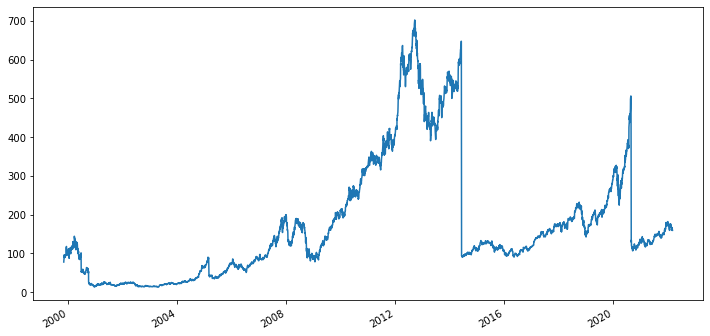

In [5]:
# Plot Close column
prices['Close'].plot(figsize = (12, 6));

In [6]:
# Convert prices to be percent changes from prior row
prices = prices.pct_change()
prices.head()

,Open,High,Low,Close,Volume
1999-11-01,NaN,NaN,NaN,NaN,NaN
1999-11-02,-0.025000,0.012393,-0.000775,0.033883,0.433120
1999-11-03,0.046410,0.019097,0.047730,0.015576,-0.177271
1999-11-04,0.005391,0.025465,-0.004691,0.026012,0.154124
1999-11-05,0.031197,0.035141,0.041925,0.056087,0.099507


In [7]:
# Drop nulls
prices.dropna(inplace = True)

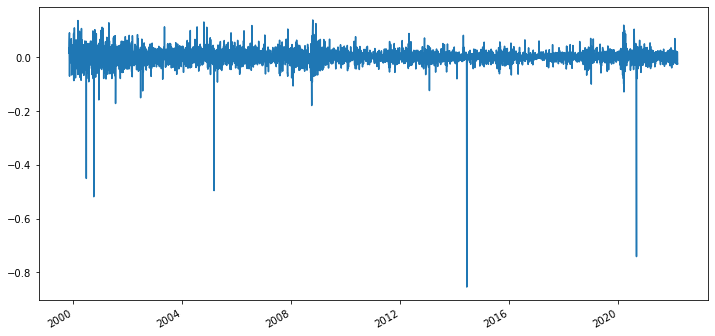

In [8]:
# Plot Close column again
prices['Close'].plot(figsize = (12,6));

## Create `Target` column
---

Our column of interest is the `Close` prices. We could build a regression model, where we predict the actual percentage change, or we could set this up as a binary classification problem:
- 1: The `Close` price was greater than or equal to the previous day
- 0: The `Close` price was lower than the previous day

We'll go with the latter option. In the cell below, let's create our binary `Target` column.

In [9]:
# Create Target column
prices['Target'] = (prices['Close'] >= 0).astype(int)

In [10]:
prices["Target"].value_counts(normalize = True)

1    0.525258
0    0.474742
Name: Target, dtype: float64

In [11]:
prices.head()

,Open,High,Low,Close,Volume,Target
1999-11-02,-0.025000,0.012393,-0.000775,0.033883,0.433120,1
1999-11-03,0.046410,0.019097,0.047730,0.015576,-0.177271,1
1999-11-04,0.005391,0.025465,-0.004691,0.026012,0.154124,1
1999-11-05,0.031197,0.035141,0.041925,0.056087,0.099507,1
1999-11-08,0.036989,0.105918,0.032738,0.091269,1.281446,1


## Train/Test Split
---

Since we're dealing with time series data, we don't want the model to be able to see the future. 

<details><summary>What do we need to do in train_test_split?</summary>

- set `shuffle=False` so that the order is maintained
</details>

In [12]:
X = prices.drop(columns = ["Target"])
y = prices['Target']

In [13]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.05)
X_train.shape, X_test.shape

((5340, 5), (282, 5))

In [14]:
y_train.mean(), y_test.mean()

(0.5262172284644194, 0.5070921985815603)

## Scaling
---

You want to scale your data for any model that uses gradient descent, which includes neural networks.

In [15]:
# Scale
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc  = sc.transform(X_test)

## `TimeseriesGenerator`
---

We'll now convert our data into series' using `TimeseriesGenerator`. The `length` parameter dictates how many rows will constitute a sample. The generator also creates our batches.

```python
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
```

In the cells below, convert your training and validation data into sequences.

In [16]:
# Create training sequences
train_seq = TimeseriesGenerator(X_train_sc, y_train,
                                length = 3, batch_size = 32)

In [17]:
# First sequence of 3 rows
train_seq[0][0][0]

array([[-0.80939525,  0.40849901, -0.05198481,  1.05400665,  0.72415082],
       [ 1.42745776,  0.64341391,  1.54751554,  0.47019279, -0.51125471],
       [ 0.14256649,  0.86660337, -0.18111319,  0.8030027 ,  0.15947478]])

In [18]:
# Compare to first three rows of scaled data
X_train_sc[0], X_train_sc[1], X_train_sc[2]

(array([-0.80939525,  0.40849901, -0.05198481,  1.05400665,  0.72415082]),
 array([ 1.42745776,  0.64341391,  1.54751554,  0.47019279, -0.51125471]),
 array([ 0.14256649,  0.86660337, -0.18111319,  0.8030027 ,  0.15947478]))

In [19]:
## Inspect our training sequences
batch_x, batch_y = train_seq[0]

In [20]:
## Check batch X shape
batch_x.shape

(32, 3, 5)

In [21]:
## Check batch y shape
batch_y.shape

(32,)

In [22]:
# Create test sequences
test_seq = TimeseriesGenerator(X_test_sc, y_test,
                               length = 3, batch_size = 32)

## Modeling time!
---

Now it's time to design our RNN model. We'll have:

- 2 `GRU` layers
- 1 `Dense` output layer

We're doing a binary classification problem.

In [23]:
train_seq[0][0][0].shape

(3, 5)

<details><summary>What should our output layer look like?</summary>

- 1 neuron
- sigmoid activation function
- this way, our model predicts a probability
</details>

In [24]:
# Design RNN
model = Sequential()

model.add(GRU(16, input_shape = train_seq[0][0][0].shape,
              return_sequences = True)) ## returns hidden state, passes back into self

model.add(GRU(8, return_sequences = False)) ## passes outputs forward to next layer
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 3, 16)             1104      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 624       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,809
Trainable params: 1,809
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(train_seq, epochs = 50, verbose = 1, validation_data = test_seq)

Epoch 1/50
167/167 [==============================] - 5s 8ms/step - loss: 0.6923 - acc: 0.5155 - val_loss: 0.6937 - val_acc: 0.5018
Epoch 2/50
167/167 [==============================] - 1s 6ms/step - loss: 0.6905 - acc: 0.5329 - val_loss: 0.6914 - val_acc: 0.5090
Epoch 3/50
167/167 [==============================] - 1s 6ms/step - loss: 0.6895 - acc: 0.5376 - val_loss: 0.6898 - val_acc: 0.5305
Epoch 4/50
167/167 [==============================] - 1s 5ms/step - loss: 0.6886 - acc: 0.5370 - val_loss: 0.6900 - val_acc: 0.5161
Epoch 5/50
167/167 [==============================] - 1s 6ms/step - loss: 0.6875 - acc: 0.5415 - val_loss: 0.6890 - val_acc: 0.5341
Epoch 6/50
167/167 [==============================] - 1s 5ms/step - loss: 0.6868 - acc: 0.5378 - val_loss: 0.6883 - val_acc: 0.5233
Epoch 7/50
167/167 [==============================] - 1s 5ms/step - loss: 0.6861 - acc: 0.5438 - val_loss: 0.6893 - val_acc: 0.5161
Epoch 8/50
167/167 [==============================] - 1s 6ms/step - loss: 0.

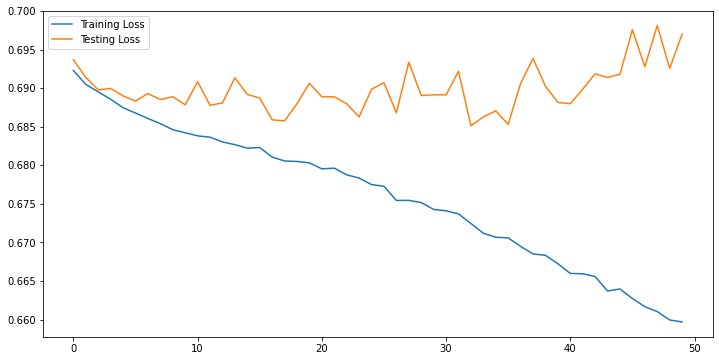

In [27]:
## Plot Training & Validation Loss
plt.figure(figsize = (12,6))
plt.plot(history.history['loss'], label = "Training Loss");
plt.plot(history.history['val_loss'], label = "Testing Loss");
plt.legend();

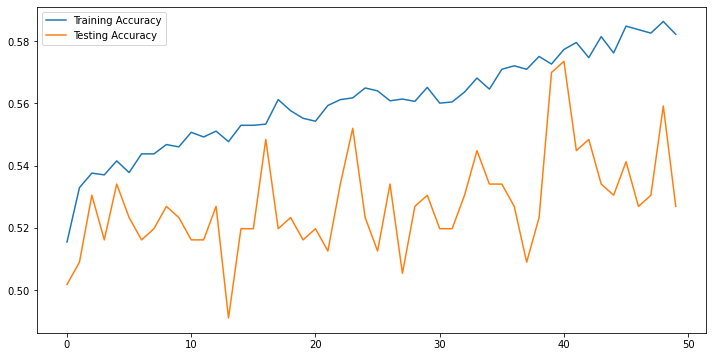

In [28]:
## Plot Training & Validation Accuracy
plt.figure(figsize = (12,6))
plt.plot(history.history['acc'], label = "Training Accuracy");
plt.plot(history.history['val_acc'], label = "Testing Accuracy");
plt.legend();

In [29]:
# Design RNN - Using LSTM instead of GRU layers
model_2 = Sequential()

model_2.add(LSTM(16, input_shape = train_seq[0][0][0].shape,
              return_sequences = True)) ## returns hidden state, passes back into self

model_2.add(LSTM(8, return_sequences = False)) ## passes outputs forward to next layer
model_2.add(Dense(8, activation = 'relu'))
model_2.add(Dense(1, activation = 'sigmoid'))

model_2.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

In [30]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 16)             1408      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,289
Trainable params: 2,289
Non-trainable params: 0
_________________________________________________________________


In [31]:
history_2 = model_2.fit(train_seq, epochs = 50, verbose = 1, validation_data = test_seq)

Epoch 1/50
167/167 [==============================] - 3s 9ms/step - loss: 0.6922 - acc: 0.5215 - val_loss: 0.6925 - val_acc: 0.5054
Epoch 2/50
167/167 [==============================] - 1s 6ms/step - loss: 0.6916 - acc: 0.5267 - val_loss: 0.6928 - val_acc: 0.5054
Epoch 3/50
167/167 [==============================] - 1s 5ms/step - loss: 0.6911 - acc: 0.5282 - val_loss: 0.6925 - val_acc: 0.5018
Epoch 4/50
167/167 [==============================] - 1s 6ms/step - loss: 0.6901 - acc: 0.5327 - val_loss: 0.6918 - val_acc: 0.5018
Epoch 5/50
167/167 [==============================] - 1s 6ms/step - loss: 0.6892 - acc: 0.5349 - val_loss: 0.6924 - val_acc: 0.5269
Epoch 6/50
167/167 [==============================] - 1s 6ms/step - loss: 0.6881 - acc: 0.5393 - val_loss: 0.6903 - val_acc: 0.5269
Epoch 7/50
167/167 [==============================] - 1s 6ms/step - loss: 0.6874 - acc: 0.5381 - val_loss: 0.6891 - val_acc: 0.5233
Epoch 8/50
167/167 [==============================] - 1s 6ms/step - loss: 0.

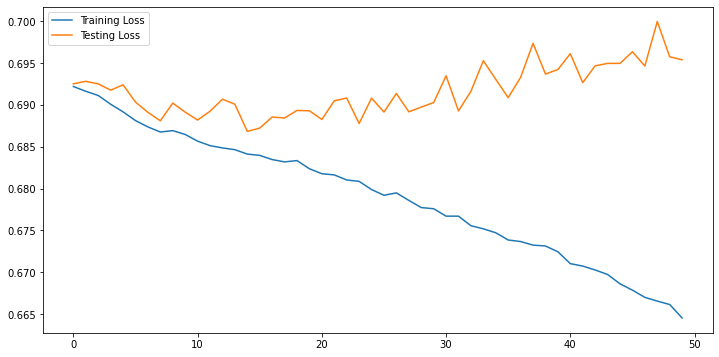

In [32]:
## Plot Training & Validation Loss
plt.figure(figsize = (12,6))
plt.plot(history_2.history['loss'], label = "Training Loss");
plt.plot(history_2.history['val_loss'], label = "Testing Loss");
plt.legend();

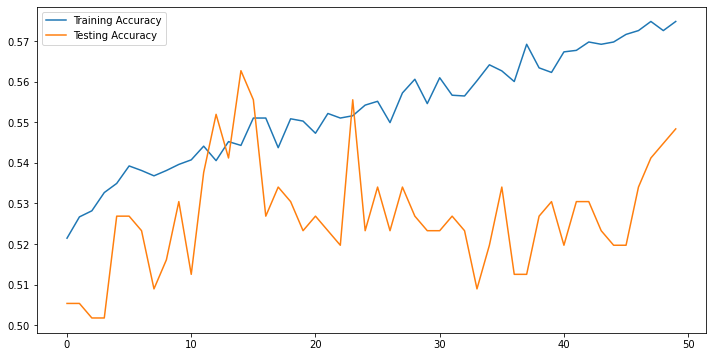

In [33]:
## Plot Training & Validation Accuracy
plt.figure(figsize = (12,6))
plt.plot(history_2.history['acc'], label = "Training Accuracy");
plt.plot(history_2.history['val_acc'], label = "Testing Accuracy");
plt.legend();

## Your turn!
---

Can you improve this model? Try to build a model that minimizes the testing loss even more!

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow import keras
from tensorflow.keras.regularizers import l2

In [35]:
model_3 = Sequential()

model_3.add(LSTM(32, input_shape = train_seq[0][0][0].shape, return_sequences = True))
model_3.add(LSTM(16, return_sequences = False))

model_3.add(Dense(16, activation = "relu", kernel_regularizer=l2(0.001)))
model_3.add(Dropout(0.1))
model_3.add(Dense(8, activation = "relu", kernel_regularizer=l2(0.001)))
model_3.add(Dropout(0.1))
model_3.add(Dense(1, activation = "sigmoid"))

model_3.compile(optimizer = Adam(learning_rate=0.001), loss = "bce", metrics = ['acc'])

In [36]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3, 32)             4864      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [37]:
def lr_scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr*np.exp(-0.1)

In [38]:
callbacks = [
    EarlyStopping(monitor = "val_loss",min_delta= 0.00001, mode = "min", verbose = 1, patience = 25, restore_best_weights=True),
    ModelCheckpoint("model_checkpoint.keras", save_best_only=True,
                    monitor = 'val_loss', mode = "min"),
    LearningRateScheduler(lr_scheduler)
]

history_3 = model_3.fit(train_seq, epochs = 100, verbose = 1,
                        validation_data = test_seq,
                        callbacks=callbacks)

Epoch 1/100
167/167 [==============================] - 3s 9ms/step - loss: 0.7114 - acc: 0.5291 - val_loss: 0.7043 - val_acc: 0.5054
Epoch 2/100
167/167 [==============================] - 1s 6ms/step - loss: 0.6991 - acc: 0.5263 - val_loss: 0.6979 - val_acc: 0.5054
Epoch 3/100
167/167 [==============================] - 1s 6ms/step - loss: 0.6944 - acc: 0.5260 - val_loss: 0.6950 - val_acc: 0.5054
Epoch 4/100
167/167 [==============================] - 1s 6ms/step - loss: 0.6927 - acc: 0.5260 - val_loss: 0.6946 - val_acc: 0.5054
Epoch 5/100
167/167 [==============================] - 1s 6ms/step - loss: 0.6918 - acc: 0.5260 - val_loss: 0.6930 - val_acc: 0.5054
Epoch 6/100
167/167 [==============================] - 1s 6ms/step - loss: 0.6917 - acc: 0.5260 - val_loss: 0.6922 - val_acc: 0.5054
Epoch 7/100
167/167 [==============================] - 1s 6ms/step - loss: 0.6912 - acc: 0.5261 - val_loss: 0.6911 - val_acc: 0.5054
Epoch 8/100
167/167 [==============================] - 1s 6ms/step - 

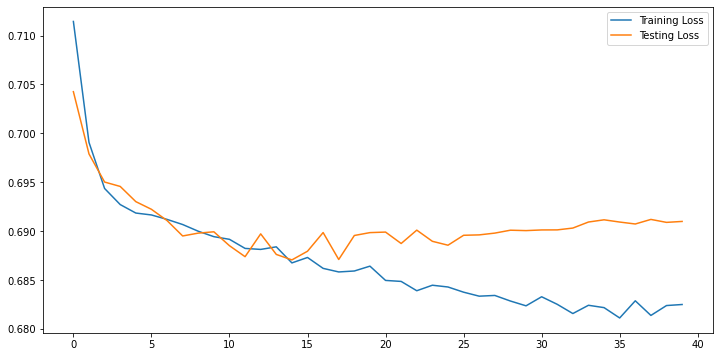

In [39]:
## Plot Training & Validation Loss
plt.figure(figsize = (12,6))
plt.plot(history_3.history['loss'], label = "Training Loss");
plt.plot(history_3.history['val_loss'], label = "Testing Loss");
plt.legend();

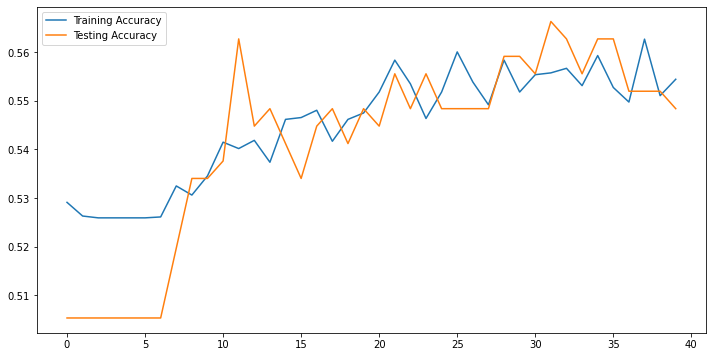

In [40]:
## Plot Training & Validation Accuracy
plt.figure(figsize = (12,6))
plt.plot(history_3.history['acc'], label = "Training Accuracy");
plt.plot(history_3.history['val_acc'], label = "Testing Accuracy");
plt.legend();

In [41]:
accuracy_score(y_test[3:],np.round(model_3.predict(test_seq)).flatten())

0.5412186379928315

In [42]:
model_3.evaluate(test_seq)

9/9 [==============================] - 0s 3ms/step - loss: 0.6871 - acc: 0.5412


[0.6870561242103577, 0.541218638420105]

### NLP with RNNs

In [43]:
spam = pd.read_csv("../datasets/sms_spam.csv")
spam.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


In [44]:
X = spam['text']
y = (spam['type'] == "spam")*1

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [46]:
tokenizer = Tokenizer(500)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


X_train_seq = pad_sequences(X_train_seq, maxlen = 100)
X_test_seq = pad_sequences(X_test_seq, maxlen = 100)

In [47]:
from tensorflow.keras.layers import Embedding

In [48]:
model_text = Sequential()

model_text.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64))#creates embeddings
model_text.add(GRU(16))
model_text.add(Dense(16, activation = 'relu'))
model_text.add(Dense(1, activation = 'sigmoid'))

model_text.compile(loss = 'bce', metrics = ['acc'], optimizer = 'adam')

history_text = model_text.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs = 20)

Epoch 1/20
131/131 [==============================] - 3s 13ms/step - loss: 0.3370 - acc: 0.8928 - val_loss: 0.0975 - val_acc: 0.9676
Epoch 2/20
131/131 [==============================] - 1s 10ms/step - loss: 0.0637 - acc: 0.9808 - val_loss: 0.0639 - val_acc: 0.9835
Epoch 3/20
131/131 [==============================] - 1s 10ms/step - loss: 0.0426 - acc: 0.9890 - val_loss: 0.0713 - val_acc: 0.9813
Epoch 4/20
131/131 [==============================] - 1s 11ms/step - loss: 0.0341 - acc: 0.9914 - val_loss: 0.0756 - val_acc: 0.9827
Epoch 5/20
131/131 [==============================] - 1s 10ms/step - loss: 0.0278 - acc: 0.9935 - val_loss: 0.0765 - val_acc: 0.9741
Epoch 6/20
131/131 [==============================] - 1s 11ms/step - loss: 0.0242 - acc: 0.9940 - val_loss: 0.0769 - val_acc: 0.9806
Epoch 7/20
131/131 [==============================] - 1s 10ms/step - loss: 0.0225 - acc: 0.9935 - val_loss: 0.0790 - val_acc: 0.9799
Epoch 8/20
131/131 [==============================] - 1s 10ms/step - 

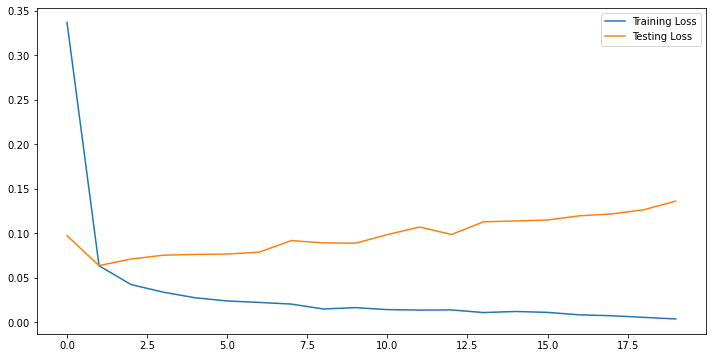

In [49]:
## Plot Training & Validation Loss
plt.figure(figsize = (12,6))
plt.plot(history_text.history['loss'], label = "Training Loss");
plt.plot(history_text.history['val_loss'], label = "Testing Loss");
plt.legend();

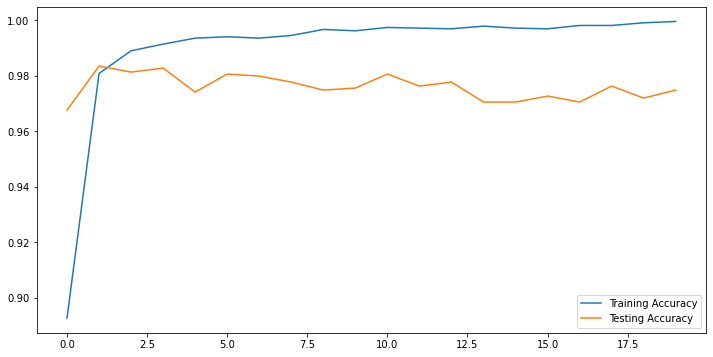

In [50]:
## Plot Training & Validation Accuracy
plt.figure(figsize = (12,6))
plt.plot(history_text.history['acc'], label = "Training Accuracy");
plt.plot(history_text.history['val_acc'], label = "Testing Accuracy");
plt.legend();